# Caracterización del THD para transitorios en el sistema de control de loudness

En este notebook se presenta la caracrerización del THD que produce el sistema de corrección de Loudness Apolo I en los transitorios.

Este análisis en particular se enfoca en el transitorio que une un punto de trabajo estable con otro punto de trabajo estable (debido a un cambio de set - point).

Para ello debemos identificar en primer lugar el tiempo de transitorio.

Por otro lado analizaremos qué nivel de THD tenemos para bloques de tiempo de 10ms.

Particularmente en este ensayo se utiliza un tono senoidal de 10kHz como señal de entrada al sistema y analizaremos el transitorio entre los setpoints de 40LKFS hacia 70LKFS y luego de 70LKFS hacia 40LKFS, de ahora en más 40->70 LKFS y 70->40 LKFS, respectivamente.

Dado que los transitorios duran más de 5 segundos, no podemos medirlo con un osciloscopio (debido a que no tienen tanta profundidad de memoria), es por ello que lo medimos con la señal I2S que sale del ESP32. 

## Configuración del slot de tiempo para calcular THD

In [1]:
slot = 20/1000 #en seg 
#Tomo 20 ms que es equivalente al tiempo de gate que se tomó en las mediciones en régimen

## Aloritmos para obtener los gráficos

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import flattop
import matplotlib.pyplot as plt
from math import floor

def decimal_to_binary(decimal_num):
    binary_str = bin(decimal_num)[2:]
    binary_str = binary_str.zfill(16)
    return binary_str


def binary_to_decimal(dataBin):
    
    data = []
    
    for i in range(16):
        if(dataBin[i]=="0"):
            data.append(0)
        else:
            data.append(1)
    
    numero_decimal = int(''.join(map(str, data[1:])), 2)
    
    if data[0] == 1:
        numero_decimal = -((1 << (len(data) - 1)) - numero_decimal)

    return numero_decimal

# Funcion de calculo de THD
def get_THD(test_signal):
    yf = np.fft.fft(test_signal)
    yf = yf[1:floor(len(yf)/2)]
    yf = np.abs(yf) # Obtengo el modulo

    # Calculo el indice donde esta la frecuencia fundamental
    f0_index = np.argmax(yf)

    # Armo vector con los indices de los armonicos
    harmonics__index = np.arange(f0_index,len(yf)-1,f0_index)

    # Creo vector con valores de los harmonicos
    harmonics_values = yf[harmonics__index]

    # Calculo thd
    thd = np.sqrt(np.sum(harmonics_values[1:]**2))/harmonics_values[0]
    
    return thd

def plot_muestras(channel0, channel1, time_axis):
    # Genera un plot con ambas señales
    plt.figure(figsize=(8,6))
    if channel0 is not None:
        plt.plot(time_axis, channel0, label='Channel 0')
    if channel1 is not None:
        plt.plot(time_axis, channel1, label='Channel 1')

    # Etiquetas y título del gráfico
    plt.xlabel('Tiempo')
    plt.ylabel('Datos')
    plt.title('Señales de Canal 0 y Canal 1')
    plt.legend()

    # Muestra el gráfico
    plt.show()


def plotTHDTransitorio(tensiones, vectorTiempos, tramo_size, sampling_rate):
    num_tramos = int( vectorTiempos[-1] / tramo_size )
    
    thd_resultados = []
    tiempos_tramos = []
    
    for i in range(num_tramos):
        inicio = int(i * tramo_size * sampling_rate)
        fin = int((i + 1) * tramo_size * sampling_rate)
        
        tramo_tensiones = tensiones[inicio:fin]
        thd = get_THD(tramo_tensiones)*100
        
        thd_resultados.append(thd)
        tiempos_tramos.append(vectorTiempos[fin])
    
    plt.figure(figsize=(8,6))
    plt.plot(tiempos_tramos, thd_resultados, label='THD')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('THD [%]')
    plt.title(f'THD en tramos de {tramo_size*1000} ms')
    plt.legend()
    plt.show()

In [3]:

def analizarArchivo(NOMBRE_ARCHIVO, tramos):
    # Paso 1: Lee el archivo CSV
    df = pd.read_csv(NOMBRE_ARCHIVO)


    # Paso 2: Filtra los datos del canal 1 y convierte de hexadecimal a decimal
    channel0 = df[df['channel'] == '0x0000000000000000']['data'].apply(lambda x: int(x, 16)).values


    # Paso 3: Filtra los datos del canal 2 y convierte de hexadecimal a decimal
    channel1 = df[df['channel'] == '0x0000000000000001']['data'].apply(lambda x: int(x, 16)).values


    # Paso 4: Ajusto datos por si uno tiene más cantidad que el otro
    largo = 0
    if len(channel0) < len(channel1):
        largo = len(channel0)
        channel1 = channel1[:largo]

    elif len(channel1) < len(channel0):
        largo = len(channel1)
        channel0 = channel0[:largo]
    else:
        largo = len(channel1)

    # Paso 5: Convierto de Decimal a BinCA2 y luego a decimal
    for i in range(largo):
        channel0[i] = binary_to_decimal( decimal_to_binary(channel0[i]) )
        channel1[i] = binary_to_decimal( decimal_to_binary(channel1[i]) )

    # Paso 6: Genero eje de tiempos
    num_samples = len(channel0)
    sampling_rate = 44100
    vectorTiempos = np.arange(0, num_samples) * (1 / sampling_rate)

    # Paso 7: Elimino todos los plots viejos
    plt.close("all")

    # Paso 8: Ploteo
    plot_muestras(channel0, None, vectorTiempos)

    # Paso 9: Calculo THD con tramos de 10ms   
    plotTHDTransitorio(channel0, vectorTiempos, tramos, sampling_rate)


## Análisis para 40LKFS a 70LKFS

C:\Users\User\AppData\Local\Temp\ipykernel_21004\2731618440.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(NOMBRE_ARCHIVO)


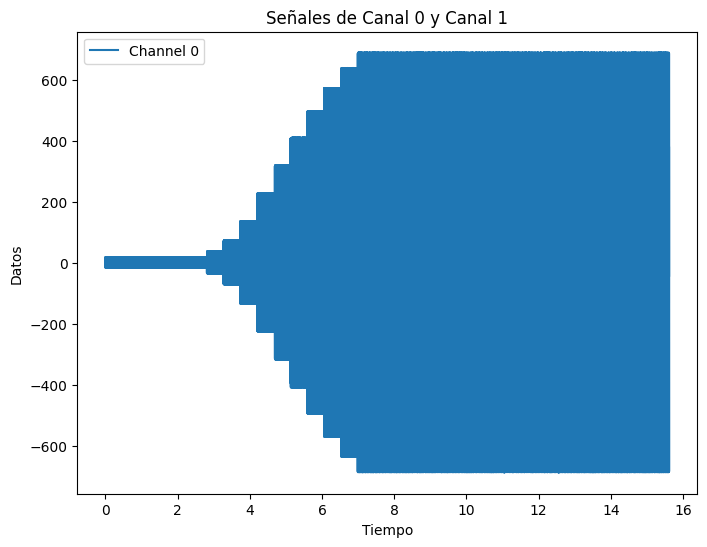

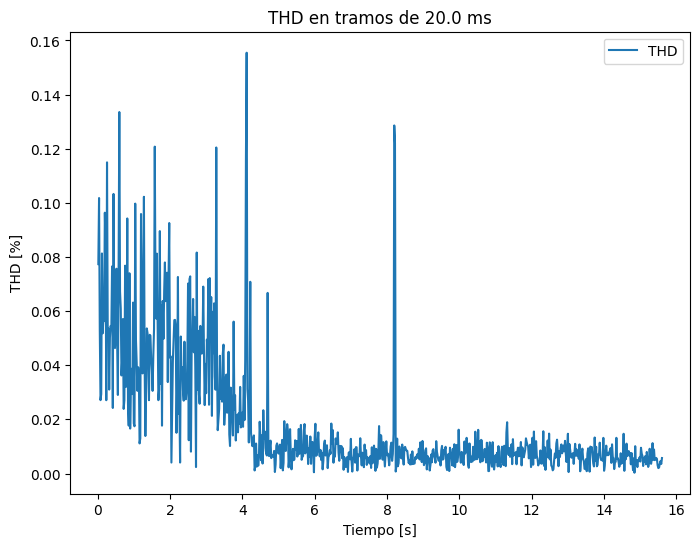

In [4]:
archivo = "10000hz_40lkfs_to_70lkfs.csv"
analizarArchivo(archivo, slot)

## Análisis para 70LKFS a 40LKFS

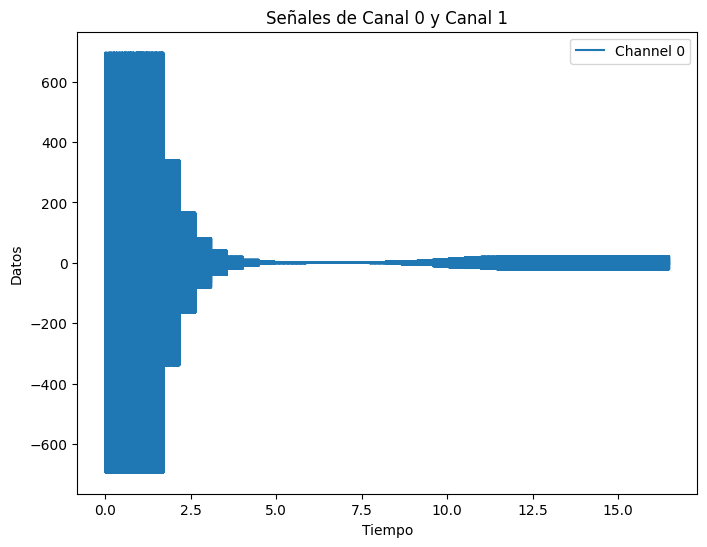

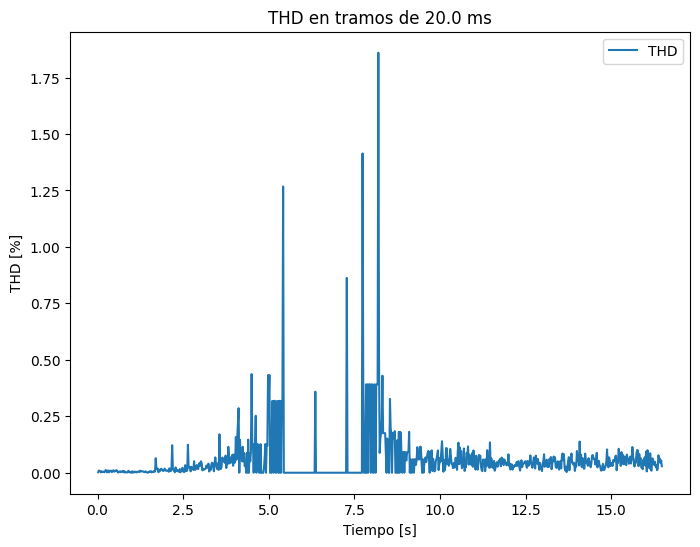

In [5]:
archivo = "10000hz_70lkfs_to_40lkfs.csv"
analizarArchivo(archivo,slot)

## Resultados:

### Tiempo de Transitorio
- 40->70LKFS: 4.187 seg 
- 70->40LKFS: 9.77 seg

Vemos que en el segundo el transitorio dura casi el doble de tiempo debido a que redujo más el loudness del valor requerido y luego volvió a aumentarle la ganancia para volver a corregir (histéresis). Eso no ocurrió en el primer caso.

Esto nos da la pauta de que cuando corrige el loudness puede ser que tarde un tiempo mayor o menor dependiendo del punto de partida. Esto es lógico dado que el sistema corrige más abruptamente cuando se encuentra más lejos que cuando está más cerca del valor de loudness deseado.


### Forma Escalonada
- Escalones de 0.4 seg 
Dicho valor corresponde al tiempo de gate para el algoritmo de medición de Loudness.
Recordemos que para calcular un valor de loudness se requieren los útimos 3 seg de audio y se calculan cada 0.4seg de tiempo de gate.


### Valores máximos de THD
- 40->70 LKFS: 0.15%
- 70->40 LKFS: 1.8%

